<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/MobileNet_V2_Training_%5BFreeze_Layers_%2B_QAT%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 213 kB 5.4 MB/s 


In [2]:
import keras
from keras.models import Sequential
from keras.applications import mobilenet_v2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tempfile

In [3]:
print(tf.__version__)

2.6.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [6]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(1204, 224, 224, 3)
(304, 224, 224, 3)
(1204, 1)
(304, 1)


In [7]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D

In [8]:
# Create base model from pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

# Freezing the convolutional base
# Prevents weights in a given layer from being updated during training 
base_model.trainable = False

## Adding additional layers

# Applies average pooling on spatial dimensions
# shape (None, 1280)
x = GlobalAveragePooling2D()(base_model.output) 

# Reshape (None, 1280) to (1, 1, 1280)
x = Reshape((1, 1, 1280))(x)

# Apply a Dropout
# Randomly selected neurons are ignored during training; helps prevent overfitting
# Dropout doesn't have any variables/weights that can be frozen during training
x = Dropout(0.3, name='Dropout')(x) 

# 2D convolutional layer
# Shape (1,1,5)
x = Conv2D(5, (1, 1), padding='same', data_format = 'channels_last')(x)

# Feeds all outputs from previous layers to all neurons
x = Activation('softmax', name='softmax')(x)  

# Reshape (1,1,5) to (,5)
x = Reshape((5,))(x)

model = Model(inputs = base_model.inputs, outputs = x)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [9]:
model.output_shape

(None, 5)

In [10]:
# Configuring the model
# Use crossentropy loss function when there are two or more label classes
# Labels are provided as integers -> Use sparse_categorical_crossentropy
# Adjust learning rate to reduce loss
#model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Train the model
training = model.fit(train_data, train_label, epochs=20, validation_data=(test_data, test_label), verbose=1)

Epoch 1/20
38/38 [==============================] - 48s 1s/step - loss: 1.5532 - accuracy: 0.3513 - val_loss: 1.1921 - val_accuracy: 0.5461
Epoch 2/20
38/38 [==============================] - 44s 1s/step - loss: 1.1332 - accuracy: 0.5498 - val_loss: 0.9215 - val_accuracy: 0.6678
Epoch 3/20
38/38 [==============================] - 44s 1s/step - loss: 0.8980 - accuracy: 0.6802 - val_loss: 0.7647 - val_accuracy: 0.7632
Epoch 4/20
38/38 [==============================] - 44s 1s/step - loss: 0.7612 - accuracy: 0.7525 - val_loss: 0.6624 - val_accuracy: 0.7961
Epoch 5/20
38/38 [==============================] - 44s 1s/step - loss: 0.6546 - accuracy: 0.7882 - val_loss: 0.5943 - val_accuracy: 0.7993
Epoch 6/20
38/38 [==============================] - 44s 1s/step - loss: 0.5923 - accuracy: 0.8140 - val_loss: 0.5432 - val_accuracy: 0.8158
Epoch 7/20
38/38 [==============================] - 44s 1s/step - loss: 0.5430 - accuracy: 0.8148 - val_loss: 0.5059 - val_accuracy: 0.8289
Epoch 8/20
38/38 [==

In [12]:
quantize_model = tfmot.quantization.keras.quantize_model

In [13]:
# q_aware stands for quantization aware
q_aware_model = quantize_model(model)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
# 'quantize_model' requires recompile
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
q_aware_model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
# All layers prefixed by "quant"
q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapperV2) (None, 112, 112, 32) 929         quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_Conv1 (QuantizeWrapper (None, 112, 112, 32) 129         quant_Conv1[0][0]                
______________________________________________________________________________________________

In [16]:
q_training = q_aware_model.fit(train_data, train_label, epochs=43, validation_data=(test_data, test_label), verbose=1)

Epoch 1/43
38/38 [==============================] - 257s 6s/step - loss: 1.9715 - accuracy: 0.2716 - val_loss: 1.3876 - val_accuracy: 0.4079
Epoch 2/43
38/38 [==============================] - 242s 6s/step - loss: 1.4096 - accuracy: 0.3854 - val_loss: 1.0426 - val_accuracy: 0.5559
Epoch 3/43
38/38 [==============================] - 242s 6s/step - loss: 1.0261 - accuracy: 0.5689 - val_loss: 0.8042 - val_accuracy: 0.7237
Epoch 4/43
38/38 [==============================] - 242s 6s/step - loss: 0.7851 - accuracy: 0.6686 - val_loss: 0.8378 - val_accuracy: 0.6382
Epoch 5/43
38/38 [==============================] - 242s 6s/step - loss: 0.6533 - accuracy: 0.7492 - val_loss: 0.6479 - val_accuracy: 0.7566
Epoch 6/43
38/38 [==============================] - 242s 6s/step - loss: 0.5482 - accuracy: 0.7957 - val_loss: 0.5124 - val_accuracy: 0.7829
Epoch 7/43
38/38 [==============================] - 242s 6s/step - loss: 0.3925 - accuracy: 0.8455 - val_loss: 0.4046 - val_accuracy: 0.8421
Epoch 8/43
38

In [17]:
_, baseline_model_accuracy = model.evaluate(test_data, test_label, verbose=1)

_, q_aware_model_accuracy = q_aware_model.evaluate(test_data, test_label, verbose=1)

10/10 [==============================] - 12s 1s/step - loss: 0.0942 - accuracy: 0.9836


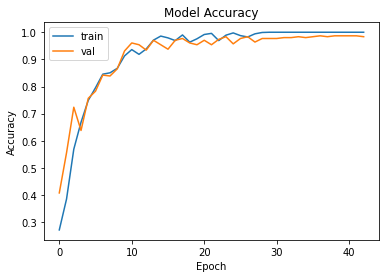

In [18]:
# Model Accuracy after Quantization Aware Training
plt.plot(q_training.history['accuracy'])
plt.plot(q_training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

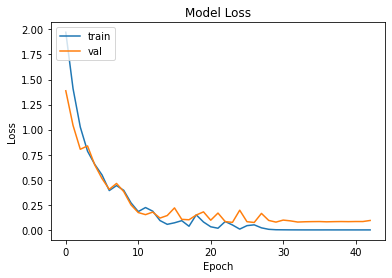

In [19]:
# Model Loss after Quantization Aware Training
plt.plot(q_training.history['loss'])
plt.plot(q_training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()